# TinyHiera with multiloader

In [14]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '4'

In [10]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from os import path

from torch import nn
from torch.nn import functional as F
from torch.nn.functional import scaled_dot_product_attention
from torch.nn.attention import SDPBackend, sdpa_kernel
from tqdm import tqdm
from einops import rearrange
from torch.optim import AdamW

import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
from omegaconf import OmegaConf, open_dict
from experanto.datasets import ChunkDataset, SimpleChunkedDataset
from experanto.utils import LongCycler, MultiEpochsDataLoader
from experanto.dataloaders import get_multisession_dataloader


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
paths = ['dynamic29513-3-5-Video-full',
         'dynamic29514-2-9-Video-full',
         'dynamic29755-2-8-Video-full',
         'dynamic29647-19-8-Video-full',
         'dynamic29156-11-10-Video-full',
         'dynamic29623-4-9-Video-full',
         'dynamic29515-10-12-Video-full',
         'dynamic29234-6-9-Video-full',
         'dynamic29712-5-9-Video-full',
         'dynamic29228-2-10-Video-full'
        ]
full_paths = [path.join("/data/mouse_polly/", f) for f in paths]

## Load Config Object from .yaml file

### Modify the config

In [12]:
from experanto.configs import DEFAULT_CONFIG as cfg
cfg.dataset.global_chunk_size = 16
cfg.dataset.global_sampling_rate = 8
cfg.dataset.modality_config.screen.include_blanks=True
cfg.dataset.modality_config.screen.valid_condition = {"tier": "train"}

cfg.dataloader.num_workers=4
cfg.dataloader.prefetch_factor=1
cfg.dataloader.batch_size=16
cfg.dataloader.pin_memory=True

### Instantiate MultiDataloader

In [8]:
%debug

> /data/experanto/experanto/datasets.py(373)initialize_transforms()
    371                     f = lambda x: torch.from_numpy((x - self._statistics[device_name]["mean"]) / self._statistics[device_name]["std"])
    372                 elif self.modality_config[device_name].transforms.get("standardize", False):
--> 373                     asdasdsad
    374                     f = lambda x:torch.from_numpy(x / self._statistics[device_name]["std"])
    375                 else:



ipdb>  self._statistics[device_name]["std"].shape


(1, 7671)


ipdb>  q


In [ ]:
# the multiple dataloader is an iterator that returns a tuple of (key, batch)
train_dl = get_multisession_dataloader(full_paths, cfg)

asdsaldsad
asdsaldsad
asdsaldsad
asdsaldsad
asdsaldsad
asdsaldsad
asdsaldsad
asdsaldsad
asdsaldsad
asdsaldsad
asdsaldsad
asdsaldsad
asdsaldsad
asdsaldsad
asdsaldsad
asdsaldsad
asdsaldsad
asdsaldsad
asdsaldsad
asdsaldsad
asdsaldsad
asdsaldsad
asdsaldsad
asdsaldsad


# Hiera

In [6]:
import torch
from hiera import Hiera
tiny_hiera = Hiera(input_size=(16,144, 256),
                     num_heads=1, 
                     stages=(4, 8), 
                     q_pool=1, 
                     in_chans=1,
                     q_stride=(2, 2, 2),
                     mask_unit_size=(1, 8, 8),
                     patch_kernel=(3, 8, 8),
                     patch_stride=(2, 4, 4),
                     patch_padding=(1, 3, 3),
                     sep_pos_embed=True,)
#tiny_hiera = torch.compile(tiny_hiera).cuda().to(torch.bfloat16);
tiny_hiera = tiny_hiera.cuda().to(torch.bfloat16);

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
example_in = torch.ones(8,1,16,144, 256).to("cuda", torch.bfloat16)
out = tiny_hiera(example_in, return_intermediates=True);
features = out[-1][-1]
features.shape

torch.Size([8, 4, 18, 32, 192])

In [8]:
example_in = torch.ones(8,1,16,144, 256).to("cuda", torch.bfloat16)
with torch.no_grad():
    for i in tqdm(range(100)):
        out = tiny_hiera(example_in, return_intermediates=True);

100% 100/100 [00:01<00:00, 74.53it/s]


In [10]:
with torch.no_grad():
    for i, (k, b) in tqdm(enumerate(train_dl)):
        videos = b["screen"].to("cuda", torch.bfloat16, non_blocking=True).permute(0,2,1,3,4)
        out = tiny_hiera(videos, return_intermediates=True);
        if i > 200:
            break

201it [00:13, 14.63it/s]


In [18]:
32*15*16

7680

In [8]:
class IndexedLinearReadout(nn.Module):
    """
    Readout module for MTM models with selectable weights based on 
    input IDs. Based on :class:`torch.nn.Linear`.
    """
    def __init__(
        self,
        unique_ids: int,
        in_features: int = 384,
        out_features: int = 1,
        bias: bool = True,
        device="cuda",
        dtype=torch.float32,
        init_std: float = 0.02,
    ):
        factory_kwargs = {"device": device, "dtype": dtype}
        super().__init__()
        self.unique_ids = unique_ids
        self.in_features = in_features
        self.out_features = out_features
        self.init_std = init_std

        self.query = nn.Parameter(
            torch.empty(1, 4, unique_ids, 32, **factory_kwargs)
        )
        self.weight = nn.Parameter(
            torch.empty(unique_ids, in_features, out_features, **factory_kwargs)
        )
        if bias:
            self.bias = nn.Parameter(
                torch.empty(1, unique_ids, out_features, **factory_kwargs)
            )
        else:
            self.register_parameter('bias', None)
        self.init_weights()

    def init_weights(self, cutoff_factor: int = 3):
        """See `TorchTitan <https://github.com/pytorch/torchtitan/blob/40a10263c5b3468ffa53b3ac98d80c9267d68155/torchtitan/models/llama/model.py#L403>`__."""
        readout_std = self.in_features**-0.5
        nn.init.trunc_normal_(
            self.weight,
            mean=0.0,
            std=readout_std,
            a=-cutoff_factor * readout_std,
            b=cutoff_factor * readout_std,
        )
        readout_std = self.in_features**-0.5
        nn.init.trunc_normal_(
            self.query,
            mean=0.0,
            std=readout_std,
            a=-cutoff_factor * readout_std,
            b=cutoff_factor * readout_std,
        )
        if self.bias is not None:
            self.bias.data.zero_()

In [9]:
class ELU1(nn.Module):
    """
    Adapted from `NeuralPredictors <https://github.com/sinzlab/neuralpredictors/blob/main/neuralpredictors/layers/activations.py>`__.
    
    Elu activation function shifted by 1 to ensure that the
    output stays positive. That is:
    Elu1(x) = Elu(x) + 1
    """

    def forward(self, x, inplace=False, eps=0.0):
        return F.elu(x, inplace=inplace) + 1.0 + eps

In [10]:
class MouseHiera(nn.Module):
    def __init__(self,
                 backbone,
                 dls,
                 dim=512,
                 dim_head=32,
                 num_heads=4):
        super().__init__()
        self.backbone=backbone
        self.num_heads=num_heads
        self.dim_head=dim_head
        self.wk = nn.Linear(dim, dim_head * num_heads, bias=False)
        self.wv = nn.Linear(dim, dim_head * num_heads, bias=False)
        self.wo = nn.Linear(dim_head * num_heads, dim, bias=False)
        self.readout = nn.ModuleDict()
        self.activation = ELU1()
        for k, v in dls.loaders.items():
            n_neurons = next(iter(v))["responses"].shape[-1]
            self.readout[k] = IndexedLinearReadout(n_neurons, in_features=dim_head*num_heads)
    
    def forward(self, x, key):
        x = self.backbone(x, return_intermediates=True)[1][-1]
        b, t, h, w, d = x.shape
        seq_len = t*h*w
        x = x.view(b, -1, d)
        k, v = self.wk(x), self.wv(x)
        q = self.readout[key].query
        n = q.shape[2]
        q = q.tile(b, 1, 16, 1)
        k = k.view(b, -1, self.num_heads, self.dim_head).transpose(1, 2)
        v = v.view(b, -1, self.num_heads, self.dim_head).transpose(1, 2)
        with sdpa_kernel(SDPBackend.FLASH_ATTENTION):
            o = F.scaled_dot_product_attention(q, k, v)
        o = o.transpose(1,2).contiguous().view(b, -1, self.num_heads * self.dim_head)
        o = self.wo(o)
        o = o.view(b, -1,n, d)
        w = r.readout[key].weight
        o = torch.einsum("btni, njr->bnt", o, w, )
        o = o + r.readout[key].bias
        return self.activation(o)

In [11]:
backbone_dim = features[-1][-1].shape[-1]
r = MouseHiera(tiny_hiera, train_dl, backbone_dim, dim_head=32,)
#opt_r = torch.compile(r, )
opt_r = r

In [12]:
torch.set_float32_matmul_precision('medium')
opt_r.backbone.to(torch.bfloat16).cuda();
opt_r = opt_r.train().to(torch.bfloat16).cuda()
opt_r = opt_r.cuda().to(torch.bfloat16)

In [13]:
k, b = next(iter(train_dl))
videos = b["screen"].to("cuda", torch.bfloat16, non_blocking=True).permute(0,2,1,3,4)
responses = b["responses"].to("cuda", torch.bfloat16, non_blocking=True)
out = opt_r(videos, k);

In [14]:
opt_r = torch.compile(r).cuda().to(torch.bfloat16)

In [15]:
criteria = nn.PoissonNLLLoss(log_input=False, reduction='mean')
opt = AdamW(opt_r.parameters(), lr=3e-4, fused=True)
import pytorch_warmup as warmup
from torch.amp import autocast
warmup_scheduler = warmup.UntunedLinearWarmup(opt, )
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(opt, 1e6, eta_min=1e-7)


In [16]:
losses, corrs, lrs = [], [], []
for train_loop in range(10):
    for i, (k, b) in tqdm(enumerate(train_dl)):
        videos = b["screen"].to("cuda", torch.bfloat16, non_blocking=True).permute(0,2,1,3,4)
        responses = b["responses"].to("cuda", torch.bfloat16, non_blocking=True)
        #with autocast(device_type='cuda', dtype=torch.bfloat16):
        #    out = opt_r(videos, k);
        #    loss = criteria(out.transpose(1,2), responses)
        out = opt_r(videos, k);
        loss = criteria(out.transpose(1,2), responses)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(opt_r.parameters(), max_norm=1.0, norm_type=2)
        opt.step()

        
        opt.zero_grad()
        losses.append(loss.item())
        with warmup_scheduler.dampening():
            lr_scheduler.step()
        
        if i % 10 ==0:
            r2 = responses.to(torch.float32).cpu().numpy().flatten()
            r1 = out.transpose(1,2).detach().cpu().to(torch.float32).numpy().flatten()
            corrs.append(np.corrcoef(r1,r2)[0,1].item())
            lrs.append(opt.param_groups[0]['lr'])
        if i % 100 ==0:
            print(np.corrcoef(r1,r2)[0,1].item())
    for k, v in train_dl.loaders.items():
        v.dataset.shuffle_valid_screen_times()

1it [00:26, 26.41s/it]

0.00016431584428726963


8it [03:07, 23.25s/it]W1016 00:01:51.353000 63620 torch/_dynamo/convert_frame.py:844] [0/8] torch._dynamo hit config.cache_size_limit (8)
W1016 00:01:51.353000 63620 torch/_dynamo/convert_frame.py:844] [0/8]    function: 'forward' (/tmp/ipykernel_63620/1360009692.py:21)
W1016 00:01:51.353000 63620 torch/_dynamo/convert_frame.py:844] [0/8]    last reason: 0/0: L['key'] == '29513-3-5'                                     
W1016 00:01:51.353000 63620 torch/_dynamo/convert_frame.py:844] [0/8] To log all recompilation reasons, use TORCH_LOGS="recompiles".
W1016 00:01:51.353000 63620 torch/_dynamo/convert_frame.py:844] [0/8] To diagnose recompilation issues, see https://pytorch.org/docs/main/torch.compiler_troubleshooting.html.
102it [03:26,  4.81it/s]

-0.000801908649691249


202it [03:46,  4.80it/s]

0.0002530274114350096


302it [04:06,  4.82it/s]

0.0015582008880866947


402it [04:27,  4.80it/s]

0.0010377658931783407


502it [04:47,  4.79it/s]

0.0009490782758868919


602it [05:07,  4.81it/s]

-0.0004281772865469735


702it [05:28,  4.81it/s]

-0.0015012284687761623


802it [05:48,  4.76it/s]

0.009016332972167529


902it [06:08,  4.80it/s]

0.01466218271534274


1002it [06:29,  4.79it/s]

0.03272050156476909


1102it [06:49,  4.80it/s]

0.042634047893760144


1202it [07:09,  4.83it/s]

0.05236881443166969


1302it [07:29,  4.80it/s]

0.07736102586462545


1402it [07:50,  4.78it/s]

0.08708378828910751


1502it [08:10,  4.79it/s]

0.09774481532873938


1602it [08:30,  4.82it/s]

0.11601788719696894


1702it [08:51,  4.77it/s]

0.12704209025264043


1802it [09:11,  4.82it/s]

0.13238606446436427


1902it [09:31,  4.79it/s]

0.11579152577018359


2002it [09:52,  4.80it/s]

0.11334690916559192


2102it [10:12,  4.82it/s]

0.12542832507900334


2202it [10:32,  4.81it/s]

0.12394158278211004


2302it [10:52,  4.75it/s]

0.137764407751125


2402it [11:13,  4.82it/s]

0.12747583261352596


2502it [11:33,  4.80it/s]

0.13207993556824493


2602it [11:53,  4.81it/s]

0.11857950924025085


2702it [12:14,  4.80it/s]

0.13855713687099955


2802it [12:34,  4.81it/s]

0.12807312846015714


2902it [12:54,  4.80it/s]

0.12951589015140527


3002it [13:15,  4.81it/s]

0.127673667816268


3102it [13:35,  4.75it/s]

0.13633022634092254


3202it [13:55,  4.77it/s]

0.13684453073846733


3302it [14:15,  4.81it/s]

0.1380544980281955


3402it [14:36,  4.79it/s]

0.13770198627571703


3502it [14:56,  4.79it/s]

0.1363137850295002


3602it [15:16,  4.81it/s]

0.12650829475419448


3702it [15:37,  4.78it/s]

0.13766284072530116


3802it [15:57,  4.79it/s]

0.13202438826514304


3902it [16:17,  4.80it/s]

0.14015386367390054


4002it [16:38,  4.81it/s]

0.1344262952246709


4050it [16:47,  4.02it/s]
2it [00:00,  4.70it/s]

0.13975162188088777


102it [00:20,  4.78it/s]

0.1498612113445249


202it [00:41,  4.80it/s]

0.14251477108957467


302it [01:01,  4.82it/s]

0.1441100341331729


402it [01:21,  4.78it/s]

0.12446529772801858


502it [01:41,  4.80it/s]

0.12506864036484786


602it [02:02,  4.80it/s]

0.1478957291441964


702it [02:22,  4.80it/s]

0.1509787942387484


802it [02:42,  4.78it/s]

0.1385887659751948


902it [03:03,  4.82it/s]

0.14412056874844123


1002it [03:23,  4.73it/s]

0.15423018804623834


1102it [03:43,  4.66it/s]

0.15245380285526638


1202it [04:04,  4.80it/s]

0.13345255179332738


1302it [04:24,  4.78it/s]

0.1567667264211928


1402it [04:45,  4.75it/s]

0.14607819433424224


1502it [05:06,  4.79it/s]

0.14528750480133767


1602it [05:27,  4.80it/s]

0.13126947502212385


1702it [05:47,  4.78it/s]

0.13549238808553732


1802it [06:07,  4.81it/s]

0.12550571360073515


1902it [06:28,  4.78it/s]

0.13894657425216375


2002it [06:48,  4.80it/s]

0.13996196903195957


2101it [07:08,  4.69it/s]

0.13719021292118327


2202it [07:29,  4.78it/s]

0.14450827807634883


2302it [07:49,  4.78it/s]

0.12389001443235746


2402it [08:09,  4.79it/s]

0.15193882245986373


2502it [08:30,  4.79it/s]

0.15152231136372177


2602it [08:50,  4.78it/s]

0.14154895879354218


2702it [09:10,  4.82it/s]

0.1562553810327569


2802it [09:31,  4.79it/s]

0.13970572608648654


2902it [09:51,  4.79it/s]

0.12988922159671487


3002it [10:12,  4.79it/s]

0.14106960108490224


3102it [10:32,  4.79it/s]

0.13986470942416104


3202it [10:52,  4.80it/s]

0.13241693347115574


3302it [11:13,  4.80it/s]

0.151960490327923


3402it [11:33,  4.74it/s]

0.15589766390128737


3502it [11:53,  4.78it/s]

0.15226138339160647


3602it [12:14,  4.78it/s]

0.16612543001737426


3702it [12:34,  4.80it/s]

0.14434244778748015


3802it [12:55,  4.74it/s]

0.14251771056267767


3902it [13:15,  4.80it/s]

0.1384003869228898


4002it [13:35,  4.78it/s]

0.1477716727704003


4050it [13:45,  4.91it/s]
2it [00:00,  4.67it/s]

0.14908782715804228


102it [00:20,  4.82it/s]

0.15315752241909542


202it [00:41,  4.78it/s]

0.15497911342668513


302it [01:01,  4.81it/s]

0.1467017307144707


402it [01:21,  4.82it/s]

0.148940440805582


502it [01:42,  4.77it/s]

0.1386134689625312


602it [02:02,  4.80it/s]

0.14059645272804264


702it [02:22,  4.82it/s]

0.1551766218407309


802it [02:43,  4.79it/s]

0.13748830551313432


902it [03:03,  4.76it/s]

0.13781028468213077


1002it [03:23,  4.81it/s]

0.14767740253008957


1102it [03:44,  4.77it/s]

0.14359072586634197


1202it [04:04,  4.82it/s]

0.15096135676935268


1302it [04:24,  4.79it/s]

0.14694665680921812


1402it [04:45,  4.77it/s]

0.13246614485875774


1502it [05:05,  4.82it/s]

0.15535926352787713


1602it [05:25,  4.79it/s]

0.13239173240066981


1702it [05:46,  4.79it/s]

0.14624558576673724


1802it [06:06,  4.77it/s]

0.14729193040482613


1902it [06:26,  4.75it/s]

0.14714398189116712


2002it [06:47,  4.76it/s]

0.15413646309594173


2102it [07:07,  4.77it/s]

0.1470044969571295


2202it [07:28,  4.79it/s]

0.13133119160682843


2302it [07:48,  4.79it/s]

0.14953270964688498


2402it [08:08,  4.79it/s]

0.13673064929086395


2502it [08:29,  4.75it/s]

0.14070487057025632


2602it [08:49,  4.79it/s]

0.14248620306780968


2702it [09:09,  4.82it/s]

0.16088712566342026


2802it [09:30,  4.79it/s]

0.13707253439505215


2902it [09:50,  4.77it/s]

0.16305391693182145


3002it [10:10,  4.81it/s]

0.1698455294140367


3101it [10:30,  4.65it/s]

0.13186017445602333


3202it [10:51,  4.79it/s]

0.1434356911683544


3302it [11:11,  4.82it/s]

0.15333593143579907


3402it [11:32,  4.79it/s]

0.1710374783868748


3502it [11:52,  4.78it/s]

0.15792321930842748


3602it [12:12,  4.76it/s]

0.15028438610892306


3702it [12:33,  4.76it/s]

0.1452212242985489


3802it [12:53,  4.73it/s]

0.1562262242892318


3902it [13:14,  4.80it/s]

0.14158312223114103


4002it [13:34,  4.77it/s]

0.15374888117940144


4050it [13:44,  4.91it/s]
2it [00:00,  4.62it/s]

0.15589343491380753


102it [00:20,  4.76it/s]

0.16764590484491568


202it [00:41,  4.77it/s]

0.14908214987384358


302it [01:01,  4.79it/s]

0.15328546984240365


402it [01:22,  4.79it/s]

0.1669447766467275


502it [01:42,  4.77it/s]

0.15540707538507376


602it [02:02,  4.80it/s]

0.1640062571587928


702it [02:23,  4.77it/s]

0.15202488194010252


802it [02:43,  4.76it/s]

0.14496575637274156


902it [03:04,  4.76it/s]

0.15504178514662148


1002it [03:24,  4.77it/s]

0.15761065514333


1102it [03:44,  4.68it/s]

0.15224722659358927


1202it [04:05,  4.77it/s]

0.1456249509620639


1302it [04:25,  4.79it/s]

0.1370918893950934


1402it [04:46,  4.77it/s]

0.14186440688029947


1502it [05:06,  4.77it/s]

0.1600722170660053


1602it [05:26,  4.77it/s]

0.13993263109670373


1702it [05:47,  4.78it/s]

0.15693474817940448


1802it [06:07,  4.81it/s]

0.17281167923163226


1902it [06:28,  4.72it/s]

0.17280612237509782


2002it [06:48,  4.77it/s]

0.15470052824253241


2102it [07:08,  4.79it/s]

0.1429988319806045


2202it [07:29,  4.78it/s]

0.16214152217823077


2302it [07:49,  4.80it/s]

0.16575691992857633


2402it [08:10,  4.81it/s]

0.16721290085147036


2502it [08:30,  4.79it/s]

0.16018644529816492


2602it [08:50,  4.77it/s]

0.15145427582182852


2702it [09:11,  4.70it/s]

0.1387038716499293


2802it [09:32,  4.68it/s]

0.14837389044582242


2902it [09:52,  4.73it/s]

0.16135560862623397


3002it [10:13,  4.78it/s]

0.15490991515786007


3102it [10:33,  4.74it/s]

0.1566909784911586


3202it [10:54,  4.74it/s]

0.1400246438679696


3301it [11:18,  3.74it/s]

0.15711430597714496


3401it [11:44,  3.82it/s]

0.14812415164014714


3502it [12:07,  4.75it/s]

0.1402994078104663


3602it [12:27,  4.77it/s]

0.16239852827976184


3702it [12:48,  4.73it/s]

0.1611537866285258


3802it [13:08,  4.77it/s]

0.14875083632786856


3901it [13:29,  3.78it/s]

0.1579564496944005


4001it [13:55,  3.76it/s]

0.14737729584940915


4050it [14:08,  4.78it/s]
1it [00:00,  3.09it/s]

0.16827903376596048


102it [00:23,  4.77it/s]

0.15401999304012395


202it [00:44,  4.77it/s]

0.16964907470230453


301it [01:04,  4.63it/s]

0.16056022154064875


402it [01:25,  4.77it/s]

0.16051856437215967


501it [01:47,  4.52it/s]

0.15522965143087017


602it [02:11,  4.79it/s]

0.1578166873553157


702it [02:32,  4.77it/s]

0.1718102014728614


802it [02:53,  4.41it/s]

0.14990327965842037


902it [03:23,  4.78it/s]

0.155593334834276


1001it [03:46,  3.79it/s]

0.16126755585157135


1101it [04:11,  3.80it/s]

0.137685684556713


1202it [04:35,  4.77it/s]

0.16353151539269267


1302it [04:56,  4.79it/s]

0.16237219985011958


1402it [05:16,  4.77it/s]

0.1590805429633266


1502it [05:37,  4.78it/s]

0.15505374175707434


1602it [05:57,  4.78it/s]

0.1660654191984892


1702it [06:17,  4.67it/s]

0.1552494981778508


1802it [06:38,  4.80it/s]

0.16184075762369002


1902it [06:58,  4.77it/s]

0.15999235338199452


2002it [07:19,  4.76it/s]

0.15454315651590958


2102it [07:39,  4.82it/s]

0.16194753659433742


2202it [08:00,  4.66it/s]

0.1518400879976975


2302it [08:20,  4.77it/s]

0.15494669478874668


2402it [08:40,  4.78it/s]

0.15314826981880422


2502it [09:01,  4.77it/s]

0.14878488356977546


2602it [09:21,  4.75it/s]

0.15495626956906275


2702it [09:42,  4.77it/s]

0.16481008812132553


2802it [10:02,  4.77it/s]

0.156609727452106


2902it [10:22,  4.76it/s]

0.14430276787668744


3002it [10:43,  4.74it/s]

0.16854534743385932


3102it [11:03,  4.79it/s]

0.15029337517079613


3202it [11:24,  4.75it/s]

0.1534498466015879


3302it [11:44,  4.71it/s]

0.17083680790961517


3402it [12:04,  4.80it/s]

0.17414130684615553


3502it [12:25,  4.79it/s]

0.1588028255951646


3602it [12:45,  4.77it/s]

0.17471851339270889


3702it [13:06,  4.78it/s]

0.16575543691465663


3802it [13:26,  4.77it/s]

0.17624473492840428


3902it [13:46,  4.80it/s]

0.1516115941875227


4002it [14:07,  4.74it/s]

0.15931496514580398


4050it [14:17,  4.73it/s]
2it [00:00,  4.64it/s]

0.1661949965423805


102it [00:20,  4.76it/s]

0.1715546999498716


202it [00:41,  4.79it/s]

0.15664123729367008


302it [01:01,  4.80it/s]

0.18660808434204904


402it [01:22,  4.71it/s]

0.16010689512588988


502it [01:42,  4.71it/s]

0.16238158121544782


602it [02:03,  4.59it/s]

0.17221811659142902


702it [02:23,  4.73it/s]

0.17492731705662373


802it [02:44,  4.75it/s]

0.15706945952596846


902it [03:04,  4.78it/s]

0.17612657829050643


1002it [03:24,  4.76it/s]

0.16820412507555832


1102it [03:45,  4.64it/s]

0.15455264860660428


1202it [04:05,  4.81it/s]

0.1630833308381771


1302it [04:26,  4.77it/s]

0.18318157786204525


1402it [04:46,  4.75it/s]

0.15979305936038976


1502it [05:06,  4.79it/s]

0.16633589426857834


1602it [05:27,  4.76it/s]

0.1672435830077356


1702it [05:47,  4.76it/s]

0.1669566826281514


1802it [06:07,  4.80it/s]

0.15894863813106386


1902it [06:28,  4.77it/s]

0.16471275385708176


2002it [06:48,  4.76it/s]

0.16344205486154956


2102it [07:09,  4.79it/s]

0.16585002549077082


2202it [07:29,  4.76it/s]

0.16450392289418656


2302it [07:50,  4.76it/s]

0.14956650202669936


2402it [08:10,  4.80it/s]

0.16602372551403216


2502it [08:30,  4.76it/s]

0.15589956559057555


2602it [08:51,  4.64it/s]

0.1495217709287079


2702it [09:11,  4.80it/s]

0.1732008254159797


2802it [09:32,  4.77it/s]

0.1581880223510147


2902it [09:52,  4.74it/s]

0.15072996240180336


3002it [10:12,  4.80it/s]

0.1553524729985955


3102it [10:33,  4.74it/s]

0.15968360255611166


3202it [10:53,  4.67it/s]

0.1647114304020529


3302it [11:14,  4.78it/s]

0.15831385089261923


3402it [11:34,  4.71it/s]

0.147418862677972


3502it [11:55,  4.69it/s]

0.15790628225963527


3602it [12:15,  4.64it/s]

0.1687122208612331


3702it [12:36,  4.73it/s]

0.16045228689056115


3802it [12:56,  4.73it/s]

0.15787563671984656


3902it [13:17,  4.76it/s]

0.17061486067646248


4002it [13:37,  4.76it/s]

0.17165030317815258


4050it [13:47,  4.89it/s]
2it [00:00,  4.61it/s]

0.1743642684965498


102it [00:20,  4.75it/s]

0.17622475547569383


202it [00:41,  4.74it/s]

0.17909377415190397


302it [01:01,  4.79it/s]

0.17114960531955362


402it [01:22,  4.75it/s]

0.1647177835949312


502it [01:42,  4.75it/s]

0.15247897800135932


602it [02:03,  4.80it/s]

0.17810711602493765


702it [02:23,  4.78it/s]

0.1545719394355604


802it [02:43,  4.79it/s]

0.16743202364510784


902it [03:04,  4.80it/s]

0.15986203062500134


1002it [03:24,  4.78it/s]

0.17331558128877284


1102it [03:44,  4.74it/s]

0.1676808277390198


1202it [04:05,  4.79it/s]

0.15513368613196513


1302it [04:25,  4.74it/s]

0.16236789816897662


1402it [04:46,  4.75it/s]

0.17369292077368528


1502it [05:06,  4.79it/s]

0.17367406514553804


1602it [05:26,  4.75it/s]

0.15781290414336277


1702it [05:47,  4.69it/s]

0.1780554899530906


1802it [06:07,  4.65it/s]

0.16189557646632782


1902it [06:28,  4.74it/s]

0.15670817789563302


2002it [06:48,  4.64it/s]

0.15724461393348027


2102it [07:09,  4.76it/s]

0.1592373594613915


2202it [07:29,  4.75it/s]

0.17003785377983843


2302it [07:50,  4.73it/s]

0.16373847207429335


2402it [08:10,  4.67it/s]

0.1670208763202856


2502it [08:31,  4.70it/s]

0.16643465236928576


2602it [08:51,  4.67it/s]

0.16777989340728242


2702it [09:12,  4.74it/s]

0.15831557166865187


2802it [09:32,  4.73it/s]

0.15593081079209126


2902it [09:53,  4.75it/s]

0.16995311030368584


3002it [10:13,  4.77it/s]

0.16219485600617115


3102it [10:34,  4.72it/s]

0.15975139890519027


3202it [10:54,  4.74it/s]

0.1606669071412403


3302it [11:15,  4.75it/s]

0.16286442565396514


3402it [11:35,  4.72it/s]

0.17273435543143853


3502it [11:55,  4.66it/s]

0.17124785460520575


3602it [12:16,  4.78it/s]

0.16485692147279443


3702it [12:36,  4.72it/s]

0.17802668243500833


3802it [12:57,  4.70it/s]

0.16618057104157993


3902it [13:17,  4.76it/s]

0.16778048254599068


4002it [13:38,  4.75it/s]

0.17107549123098986


4050it [13:47,  4.89it/s]
2it [00:00,  4.59it/s]

0.1748799710874164


102it [00:20,  4.77it/s]

0.15640456595719177


202it [00:41,  4.69it/s]

0.16144892670249109


302it [01:01,  4.76it/s]

0.1635109373527464


402it [01:22,  4.74it/s]

0.16108041182901695


502it [01:42,  4.74it/s]

0.15466645196435655


602it [02:03,  4.65it/s]

0.152082845899223


702it [02:23,  4.73it/s]

0.1722072363017764


802it [02:43,  4.72it/s]

0.15872004946372315


902it [03:04,  4.81it/s]

0.1671078475004349


1002it [03:24,  4.76it/s]

0.16940083096786007


1102it [03:45,  4.77it/s]

0.16288574738678138


1202it [04:05,  4.78it/s]

0.17198081350842392


1302it [04:25,  4.79it/s]

0.16892906047811712


1402it [04:46,  4.75it/s]

0.16348483226621452


1501it [05:10,  3.81it/s]

0.15894623564810761


1602it [05:32,  4.76it/s]

0.17071536117316394


1702it [05:53,  4.72it/s]

0.16460989930828712


1802it [06:13,  4.73it/s]

0.15834881695268124


1902it [06:34,  4.66it/s]

0.15759313613628895


2002it [06:54,  4.76it/s]

0.1675856362031477


2102it [07:15,  4.78it/s]

0.16876284156497368


2202it [07:35,  4.74it/s]

0.1665186867814818


2302it [07:56,  4.69it/s]

0.17550452547505266


2402it [08:16,  4.73it/s]

0.18465173754375305


2502it [08:36,  4.70it/s]

0.16765179298771454


2602it [08:57,  4.70it/s]

0.1697090025597812


2702it [09:17,  4.71it/s]

0.18145639020697013


2802it [09:38,  4.69it/s]

0.16372547659746622


2902it [09:58,  4.68it/s]

0.17020392798612222


3002it [10:19,  4.81it/s]

0.17190615563099648


3102it [10:39,  4.73it/s]

0.15262653531793113


3202it [11:00,  4.67it/s]

0.17828866070212165


3302it [11:20,  4.71it/s]

0.1558814348080297


3402it [11:41,  4.69it/s]

0.1446755609341303


3502it [12:01,  4.70it/s]

0.1697804028564079


3602it [12:21,  4.77it/s]

0.15216385309668598


3702it [12:42,  4.75it/s]

0.1711074730404765


3802it [13:02,  4.74it/s]

0.16176535390455332


3902it [13:23,  4.72it/s]

0.14599361699808247


4002it [13:43,  4.76it/s]

0.15114987709246447


4050it [13:53,  4.86it/s]
2it [00:00,  4.60it/s]

0.17794492261498168


102it [00:20,  4.76it/s]

0.1677765743904031


168it [00:34,  4.87it/s]

KeyboardInterrupt



In [29]:
losses, corrs = [], []
for _ in tqdm(range(500)):
    
    videos = b["screen"].to("cuda", torch.bfloat16, non_blocking=True).permute(0,2,1,3,4)
    responses = b["responses"].to("cuda", torch.bfloat16, non_blocking=True)
    with autocast("cuda", )
        out = opt_r.generate(videos, k);
    loss = criteria(out.transpose(1,2), responses)
    scaler.scale(loss).backward()
    scaler.step(opt)
    scaler.update()
    opt.zero_grad()
    losses.append(loss.item())
    neuron=0
    r2 = responses.to(torch.float32).cpu().numpy().flatten()
    r1 = out.transpose(1,2).detach().cpu().to(torch.float32).numpy().flatten()
    corrs.append(np.corrcoef(r1,r2)[0,1].item())

  0% 0/500 [00:00<?, ?it/s]


RuntimeError: "_amp_foreach_non_finite_check_and_unscale_cuda" not implemented for 'BFloat16'

## Overfitting

In [19]:
plt.plot(corrs)

NameError: name 'corrs' is not defined

In [16]:
plt.plot(losses)

NameError: name 'losses' is not defined

(0.0, 0.4)

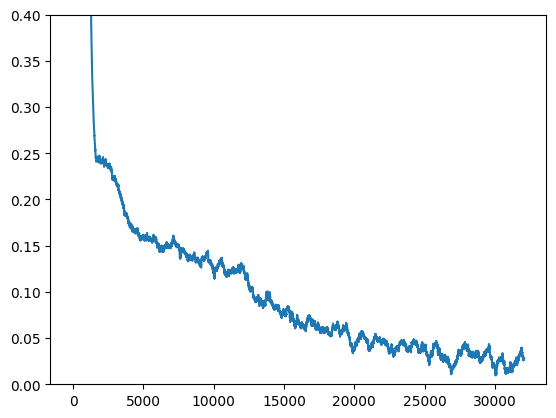

In [27]:
plt.plot(np.convolve(losses,np.ones((500,)), 'valid')/500)
plt.ylim([0,.4])

In [ ]:
plt.plot(corrs)

(0.0, 0.2)

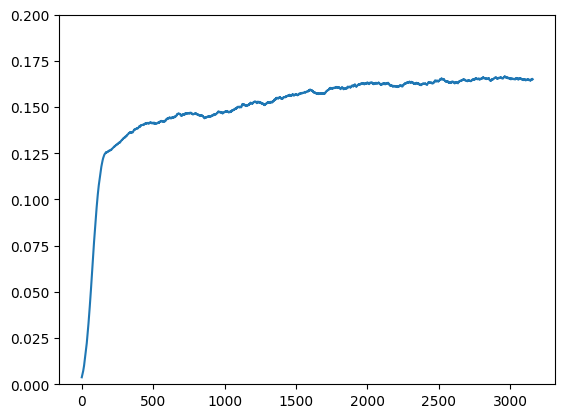

In [30]:
plt.plot(np.convolve(corrs,np.ones((100,)), 'valid')/100)
plt.ylim([0,.2])

In [24]:
with torch.no_grad():
    for i, (k, b) in tqdm(enumerate(train_dl)):
        videos = b["screen"].to("cuda", torch.bfloat16, non_blocking=True).permute(0,2,1,3,4)
        out = opt_r(videos, k);
        if i > 200:
            break

7it [00:14,  2.00s/it]/usr/local/lib/python3.10/dist-packages/torch/_inductor/compile_fx.py:168: UserWarning: TensorFloat32 tensor cores for float32 matrix multiplication available but not enabled. Consider setting `torch.set_float32_matmul_precision('high')` for better performance.
  warnings.warn(
8it [00:22,  4.01s/it]W1015 15:32:29.407000 20839 torch/_dynamo/convert_frame.py:844] [0/8] torch._dynamo hit config.cache_size_limit (8)
W1015 15:32:29.407000 20839 torch/_dynamo/convert_frame.py:844] [0/8]    function: 'forward' (/tmp/ipykernel_20839/2467812288.py:21)
W1015 15:32:29.407000 20839 torch/_dynamo/convert_frame.py:844] [0/8]    last reason: 0/0: L['key'] == '29513-3-5'                                     
W1015 15:32:29.407000 20839 torch/_dynamo/convert_frame.py:844] [0/8] To log all recompilation reasons, use TORCH_LOGS="recompiles".
W1015 15:32:29.407000 20839 torch/_dynamo/convert_frame.py:844] [0/8] To diagnose recompilation issues, see https://pytorch.org/docs/main/torch

In [25]:
with torch.no_grad():
    for i, (k, b) in tqdm(enumerate(train_dl)):
        videos = b["screen"].to("cuda", torch.bfloat16, non_blocking=True).permute(0,2,1,3,4)
        out = opt_r(videos, k);
        if i > 200:
            break

201it [00:09, 22.31it/s]


In [106]:
with torch.no_grad():
    for i, (k, b) in tqdm(enumerate(train_dl)):
        videos = b["screen"].to("cuda", torch.bfloat16, non_blocking=True).permute(0,2,1,3,4)
        out = opt_r(videos, k);
        if i > 200:
            break

201it [00:08, 22.55it/s]


In [30]:
with torch.no_grad():
    for i, (k, b) in tqdm(enumerate(train_dl)):
        videos = b["screen"].to("cuda", torch.bfloat16, non_blocking=True).permute(0,2,1,3,4)
        out = tiny_hiera(videos,);
        if i > 200:
            break

201it [00:03, 52.64it/s]


In [41]:
responses[:,:,:].std((0,1))

tensor(5.4375, device='cuda:0', dtype=torch.bfloat16)

In [193]:
videos = b["screen"].to("cuda", torch.bfloat16, non_blocking=True).permute(0,2,1,3,4)
responses = b["responses"].to("cuda", torch.bfloat16, non_blocking=True)

In [194]:
from torch.amp import autocast

In [182]:
opt_r.to(torch.bfloat16);

In [183]:
with autocast(device_type='cuda', dtype=torch.float16):
    out = opt_r(videos, k);


In [57]:
out.shape

torch.Size([8, 7495, 16])

In [58]:
loss = criteria(out.transpose(1,2), responses)

In [59]:
loss.backward()

In [61]:
opt.step()

In [63]:
opt.zero_grad()

In [65]:
loss.shape

torch.Size([])

In [186]:
videos.shape

torch.Size([8, 1, 16, 144, 256])

In [196]:
opt_r = opt_r.to(torch.bfloat16)

In [197]:
out = opt_r(videos, k);

In [ ]:
out = opt_r(videos, k);

In [ ]:
losses = []
for _ in tqdm(range(1000)):
    #with autocast(device_type='cuda', dtype=torch.bfloat16):
    videos = b["screen"].to("cuda", torch.bfloat16, non_blocking=True).permute(0,2,1,3,4)
    responses = b["responses"].to("cuda", torch.bfloat16, non_blocking=True)
    out = opt_r(videos, k);
    loss = criteria(out.transpose(1,2), responses)
    loss.backward()
    opt.step()
    opt.zero_grad()
    losses.append(loss.item())

 58% 576/1000 [01:24<01:01,  6.84it/s]

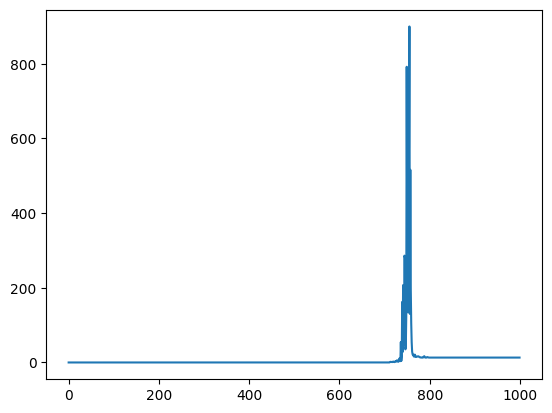

In [218]:
plt.plot(losses)

In [141]:
out.shape

torch.Size([8, 7495, 16])

In [142]:
responses.shape

torch.Size([8, 16, 7495])

In [51]:
neuron=66

0.12096827660364878

In [38]:
out.shape

torch.Size([8, 7495, 16])

In [ ]:
for batch_no, (data_key, data) in tqdm(enumerate(LongCycler(dataloaders["train"])), total=n_iterations,
                                       desc="Epoch {}".format(epoch)):

    loss = full_objective(model, dataloaders["train"], data_key, *data)
    # loss = torch.sum(loss)
    loss.backward()

In [33]:
full_out.shape

torch.Size([8, 7671, 16])

In [ ]:
r.readout["29513-3-5"].bias.shape

In [97]:
full_out = rearrange(full_out, 'b (n t) c -> b t n c', n=7671, t=16)

In [49]:
full_out.shape

torch.Size([8, 16, 7671, 384])

In [50]:
w = r.readout["29513-3-5"].weight

In [51]:
w.shape

torch.Size([7671, 256, 1])

In [54]:
torch.einsum("btni, njr->bnt", full_out, w, )

torch.Size([8, 7671, 16])

In [93]:
full_out.shape

torch.Size([8, 7671, 256])

In [75]:
torch.isnan(full_out).sum()

tensor(960416, device='cuda:0')

In [37]:
with torch.no_grad():
    for i in tqdm(range(100)):
        r(videos, "29513-3-5");

100% 100/100 [00:00<00:00, 110.38it/s]


In [39]:
with torch.no_grad():
    for i in tqdm(range(100)):
        r(videos, "29513-3-5");

100% 100/100 [00:00<00:00, 110.43it/s]


In [43]:
for i in tqdm(range(100)):
    r(videos, "29513-3-5");

100% 100/100 [00:00<00:00, 103.98it/s]


In [29]:
import torch
n_params=0
for n, p in r.readout.named_parameters():
    print(n, p.shape, torch.numel(p))
    n_params += torch.numel(p)
print(n_params)

29513-3-5.query torch.Size([1, 8, 7671, 32]) 1963776
29513-3-5.weight torch.Size([7671, 256, 1]) 1963776
29513-3-5.bias torch.Size([1, 7671, 1]) 7671
29514-2-9.query torch.Size([1, 8, 7495, 32]) 1918720
29514-2-9.weight torch.Size([7495, 256, 1]) 1918720
29514-2-9.bias torch.Size([1, 7495, 1]) 7495
29755-2-8.query torch.Size([1, 8, 8122, 32]) 2079232
29755-2-8.weight torch.Size([8122, 256, 1]) 2079232
29755-2-8.bias torch.Size([1, 8122, 1]) 8122
29647-19-8.query torch.Size([1, 8, 8202, 32]) 2099712
29647-19-8.weight torch.Size([8202, 256, 1]) 2099712
29647-19-8.bias torch.Size([1, 8202, 1]) 8202
29156-11-10.query torch.Size([1, 8, 7440, 32]) 1904640
29156-11-10.weight torch.Size([7440, 256, 1]) 1904640
29156-11-10.bias torch.Size([1, 7440, 1]) 7440
29623-4-9.query torch.Size([1, 8, 7908, 32]) 2024448
29623-4-9.weight torch.Size([7908, 256, 1]) 2024448
29623-4-9.bias torch.Size([1, 7908, 1]) 7908
29515-10-12.query torch.Size([1, 8, 7863, 32]) 2012928
29515-10-12.weight torch.Size([7863,

In [23]:
full_out.shape

torch.Size([8, 7671, 256])

In [38]:
30684/16

1917.75

In [ ]:
30684

In [35]:
with sdpa_kernel(SDPBackend.FLASH_ATTENTION):
    with torch.no_grad():
        for i in tqdm(range(100)):
            r(videos, "29513-3-5")

torch.Size([8, 4, 18, 16, 384])
torch.Size([8, 1152, 256])
torch.Size([8, 1152, 256])
torch.Size([32, 8, 7671, 32])
torch.Size([8, 8, 1152, 32])
torch.Size([8, 8, 1152, 32])


In [42]:
with sdpa_kernel(SDPBackend.FLASH_ATTENTION):
    with torch.no_grad():
        for i in tqdm(range(100)):
            r(videos, "29513-3-5")

100% 100/100 [00:00<00:00, 110.38it/s]


In [20]:
example_in = torch.ones(32,1,16,144, 144).to("cuda", torch.bfloat16)
with torch.no_grad():
    for i in tqdm(range(1000)):
        tiny_hiera(example_in);

100% 1000/1000 [00:21<00:00, 46.31it/s]


In [11]:
24*32*16

12288

In [22]:
with torch.no_grad():
    for i, (k, b) in tqdm(enumerate(dl)):
        video_tensor = b["screen"].to("cuda", torch.bfloat16, non_blocking=True).permute(0,2,1,3,4)
        _ = b["responses"].to("cuda", torch.bfloat16, non_blocking=True)
        _ = b["eye_tracker"].to("cuda", torch.bfloat16, non_blocking=True)
        _ = b["treadmill"].to("cuda", torch.bfloat16, non_blocking=True)
        #tiny_hiera(video_tensor);
        if i >300:
            break

301it [00:17, 17.03it/s]


In [24]:
with torch.no_grad():
    for i, (k, b) in tqdm(enumerate(dl)):
        video_tensor = b["screen"].to("cuda", torch.bfloat16, non_blocking=True).permute(0,2,1,3,4)
        _ = b["responses"].to("cuda", torch.bfloat16, non_blocking=True)
        _ = b["eye_tracker"].to("cuda", torch.bfloat16, non_blocking=True)
        _ = b["treadmill"].to("cuda", torch.bfloat16, non_blocking=True)
        tiny_hiera(video_tensor);
        if i >300:
            break

301it [00:22, 13.28it/s]


In [25]:
import torch
n_params=0
for n, p in tiny_hiera.named_parameters():
    #print(n, p.shape, torch.numel(p))
    n_params += torch.numel(p)
print(n_params)

4891336


In [2]:
import hiera

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
from hiera import Hiera


In [3]:
hiera

<module 'hiera' from '/usr/local/lib/python3.10/dist-packages/hiera/__init__.py'>

In [1]:
from hiera import Hiera
model = Hiera.from_pretrained("facebook/hiera_base_224.mae_in1k_ft_in1k")  # mae pt then in1k ft'd model
model = Hiera.from_pretrained("facebook/hiera_base_224.mae_in1k") # just mae pt, no ft

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model = Hiera.from_pretrained("facebook/hiera_tiny_224.mae_in1k") # just mae pt, no ft

In [3]:

import torch
from hiera import Hiera
my_tiny_hiera = Hiera(embed_dim=96, num_heads=1, stages=(1, 2, 7, 2))

In [4]:
my_cut_hiera = Hiera(input_size=(16,144, 144),
                     num_heads=1, 
                     stages=(1, 2, 2), 
                     q_pool=1, 
                     in_chans=1,
                     q_stride=(1, 2, 2),
                     mask_unit_size=(1, 8, 8),
                     patch_kernel=(3, 7, 7),
                     patch_stride=(2, 4, 4),
                     patch_padding=(1, 3, 3),
                     sep_pos_embed=True,)

In [5]:
my_cut_hiera.eval().cuda().to(torch.bfloat16);

In [6]:
from tqdm import tqdm

In [11]:
example_in = torch.ones(32,1,16,144, 144).to("cuda", torch.bfloat16)
with torch.no_grad():
    for i in tqdm(range(1000)):
        my_cut_hiera(example_in);

 19% 193/1000 [00:15<01:06, 12.07it/s]
Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f167ca8b370>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 

KeyboardInterrupt



In [125]:
out = my_cut_hiera(torch.ones(1,1,16,144,144).cuda(), return_intermediates=True)

In [122]:
(out[1])[1].shape

torch.Size([1, 8, 18, 18, 192])

In [81]:
36*4

144

In [69]:
my_cut_hiera.head.projection.weight.shape

torch.Size([1000, 384])

In [75]:
import numpy as np

In [76]:
np.sqrt(384)

np.float64(19.595917942265423)

In [40]:
%debug

> /usr/local/lib/python3.10/dist-packages/hiera/hiera.py(413)forward()
    411             else None,
    412         )
--> 413         x = x + self.get_pos_embed()
    414         x = self.unroll(x)
    415 



ipdb>  x.shape


torch.Size([1, 3888, 96])


ipdb>  self.get_pos_embed().shape


torch.Size([1, 10368, 96])


ipdb>  q


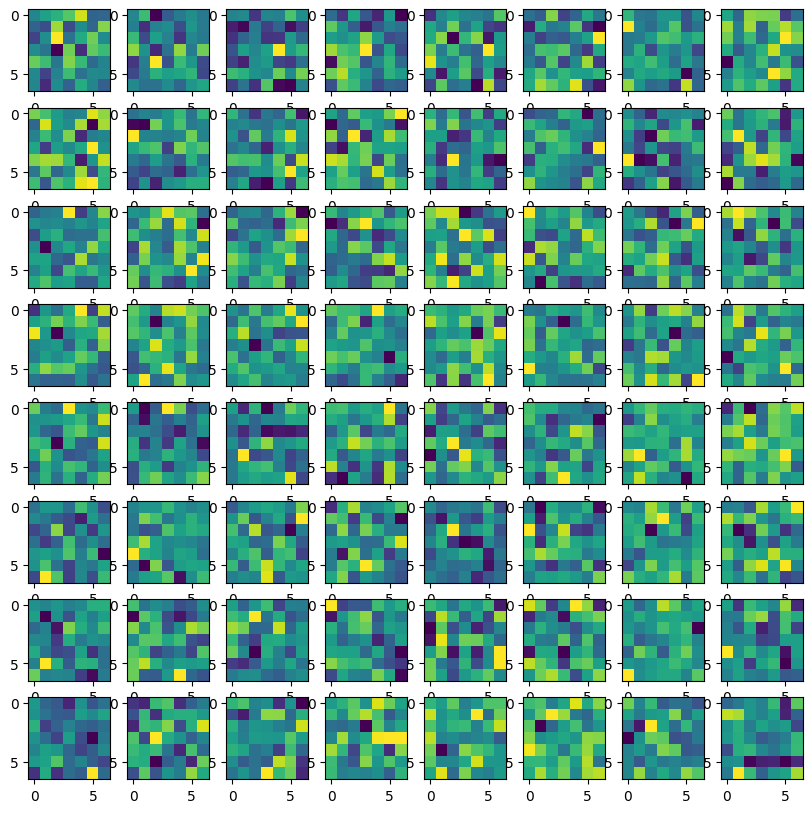

In [83]:
fig, axs = plt.subplots(8,8, figsize=(10,10))
for i, ax in enumerate(axs.ravel()):
    ax.imshow(my_cut_hiera.patch_embed.proj.weight.data[i,0].cpu().numpy())

In [2]:
import torch

In [7]:
some_weights = torch.load("mae_hiera_tiny_224.pth")
my_cut_hiera.load_state_dict(some_weights["model_state"], strict=False)


/tmp/ipykernel_248295/1124240724.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  some_weights = torch.load("mae_hiera_tiny_224.pth")


RuntimeError: Error(s) in loading state_dict for Hiera:
	size mismatch for pos_embed: copying a param with shape torch.Size([1, 3136, 96]) from checkpoint, the shape in current model is torch.Size([1, 2304, 96]).

In [ ]:
fig, axs = plt.subplots(8,12, figsize=(12,8))
for i, ax in enumerate(axs.ravel()):
    ax.imshow(my_cut_hiera.patch_embed.proj.weight.data[i,2].cpu().numpy(), cmap="hot")
    ax.axis("off")

In [8]:
n_params=0
for n, p in my_tiny_hiera.named_parameters():
    #print(n, p.shape, torch.numel(p))
    n_params += torch.numel(p)
print(n_params)

27910216


In [9]:
n_params=0
for n, p in model.named_parameters():
    print#(n, p.shape, torch.numel(p))
    n_params += torch.numel(p)
print(n_params)

27910216


In [10]:
n_params=0
for n, p in my_cut_hiera.named_parameters():
    #print(n, p.shape, torch.numel(p))
    n_params += torch.numel(p)
print(n_params)

4987336


In [11]:
my_cut_hiera.to("cuda", torch.bfloat16);
my_tiny_hiera.to("cuda", torch.bfloat16);


In [12]:
from tqdm import tqdm

In [13]:
with torch.no_grad():
    for i in tqdm(range(100)):
        my_cut_hiera(torch.ones(500,3,256,144).to("cuda", torch.bfloat16));

100% 100/100 [00:16<00:00,  6.09it/s]


In [15]:
example = torch.ones(500,3,224,224).to("cuda", torch.bfloat16)
with torch.no_grad():
    for i in tqdm(range(100)):
        out = my_tiny_hiera(example, );

100% 100/100 [00:22<00:00,  4.48it/s]


In [16]:
my_tiny_hiera = torch.compile(my_tiny_hiera,)

In [9]:
my_tiny_hiera.to("cuda", torch.bfloat16);
example = torch.ones(500,3,224,224).to("cuda", torch.bfloat16)
out = my_tiny_hiera(example, );

In [19]:
# default
example = torch.ones(500,3,224,224).to("cuda", torch.bfloat16)
with torch.no_grad():
    for i in tqdm(range(100)):
        out = my_tiny_hiera(example, );

100% 100/100 [00:13<00:00,  7.60it/s]


In [21]:
torch.set_float32_matmul_precision('high')
# default
example = torch.ones(500,3,224,224).to("cuda", torch.bfloat16)
with torch.no_grad():
    for i in tqdm(range(100)):
        out = my_tiny_hiera(example, );

100% 100/100 [00:13<00:00,  7.64it/s]


In [22]:
torch.set_float32_matmul_precision('medium')

In [24]:
example = torch.ones(500,3,224,224).to("cuda", torch.bfloat16)


100% 100/100 [00:13<00:00,  7.63it/s]


In [30]:
example = torch.ones(500,3,224,224).to("cuda", torch.bfloat16)
with torch.no_grad():
    for i in tqdm(range(100)):
        out = my_tiny_hiera(example, );

100% 100/100 [00:13<00:00,  7.65it/s]


In [32]:
with sdpa_kernel(SDPBackend.FLASH_ATTENTION):
    with torch.no_grad():
        for i in tqdm(range(100)):
            out = my_tiny_hiera(example, );

100% 100/100 [00:13<00:00,  7.65it/s]


In [36]:
torch.backends.cuda.enable_flash_sdp(False)
with torch.no_grad():
    for i in tqdm(range(100)):
        out = my_tiny_hiera(example, );

100% 100/100 [00:22<00:00,  4.46it/s]


In [37]:
torch.backends.cuda.enable_flash_sdp(True)
with torch.no_grad():
    for i in tqdm(range(100)):
        out = my_tiny_hiera(example, );

100% 100/100 [00:22<00:00,  4.37it/s]


In [4]:
import torch

In [15]:
example.shape


torch.Size([500, 3, 224, 224])

In [5]:
torch.__version__

'2.6.0.dev20240913+cu121'

In [14]:
%debug

> /usr/local/lib/python3.10/dist-packages/hiera/hiera.py(100)forward()
     98         if hasattr(F, "scaled_dot_product_attention"):
     99             # Note: the original paper did *not* use SDPA, it's a free boost!
--> 100             x = F.scaled_dot_product_attention(q, k, v)
    101         else:
    102             attn = (q * self.scale) @ k.transpose(-1, -2)



ipdb>  F


<module 'torch.nn.functional' from '/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py'>


ipdb>  k.shape


torch.Size([500, 1, 49, 64, 96])


ipdb>  q


In [21]:
from tqdm import tqdm
torch.set_float32_matmul_precision('medium')
from torch.nn.attention import SDPBackend, sdpa_kernel
with sdpa_kernel(SDPBackend.FLASH_ATTENTION):
    with torch.no_grad():
        for i in tqdm(range(100)):
            out = my_tiny_hiera(torch.ones(10,3,224,224).to("cuda", torch.bfloat16), );

  0% 0/100 [00:00<?, ?it/s]


RuntimeError: No available kernel. Aborting execution.

In [2]:
128*8*3*224*224*2 / 1e9

0.308281344

In [ ]:
! 

In [ ]:
import torch
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

checkpoint = "./checkpoints/sam2.1_hiera_large.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_l.yaml"
predictor = SAM2ImagePredictor(build_sam2(model_cfg, checkpoint))